In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#Librerie e funzioni importate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [62]:
#Caricamento e analisi iniziale dei dati
data = pd.read_csv('movie_info.csv')
print(data.head())

                          movie_title  release_date  season  phase  \
0                            Iron Man    May 2 2008       1      1   
1                 The Incredible Hulk  June 13 2008       1      1   
2                          Iron Man 2    May 7 2010       1      1   
3                                Thor    May 6 2011       1      1   
4  Captain America: The First Avenger  July 22 2011       2      1   

   production_budget_in_million_(USD)  worldwide_collection_in_million_(USD)  \
0                                 140                                 585.37   
1                                 150                                 264.77   
2                                 200                                 623.93   
3                                 150                                 449.33   
4                                 140                                 370.57   

   tomatometer  tomato_audience_score  imdb  metascore  meta_user_score  
0          9.4          

In [63]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   movie_title                            27 non-null     object 
 1   release_date                           27 non-null     object 
 2   season                                 27 non-null     int64  
 3   phase                                  27 non-null     int64  
 4   production_budget_in_million_(USD)     27 non-null     int64  
 5   worldwide_collection_in_million_(USD)  27 non-null     float64
 6   tomatometer                            27 non-null     float64
 7   tomato_audience_score                  27 non-null     float64
 8   imdb                                   27 non-null     float64
 9   metascore                              27 non-null     float64
 10  meta_user_score                        27 non-null     float64
dtypes: float

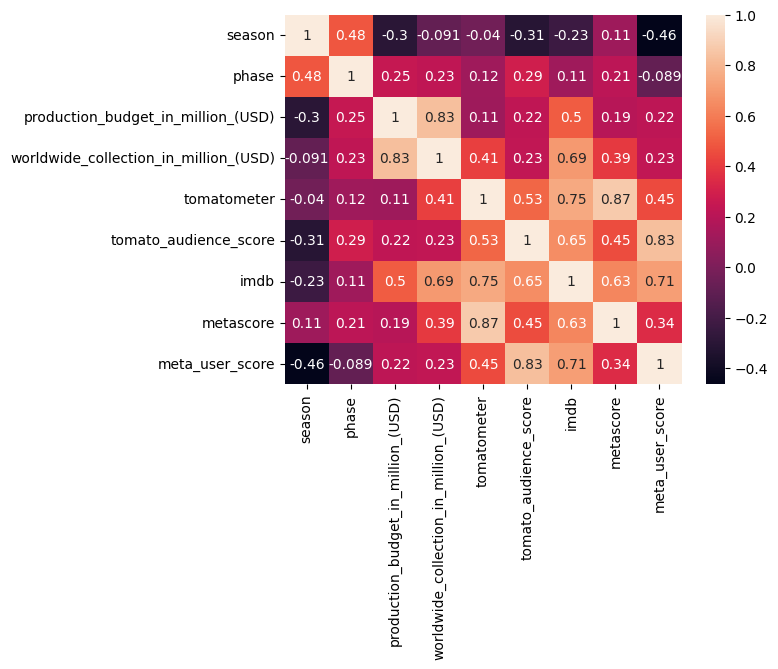

In [64]:
# Calcolo della matrice di correlazione
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

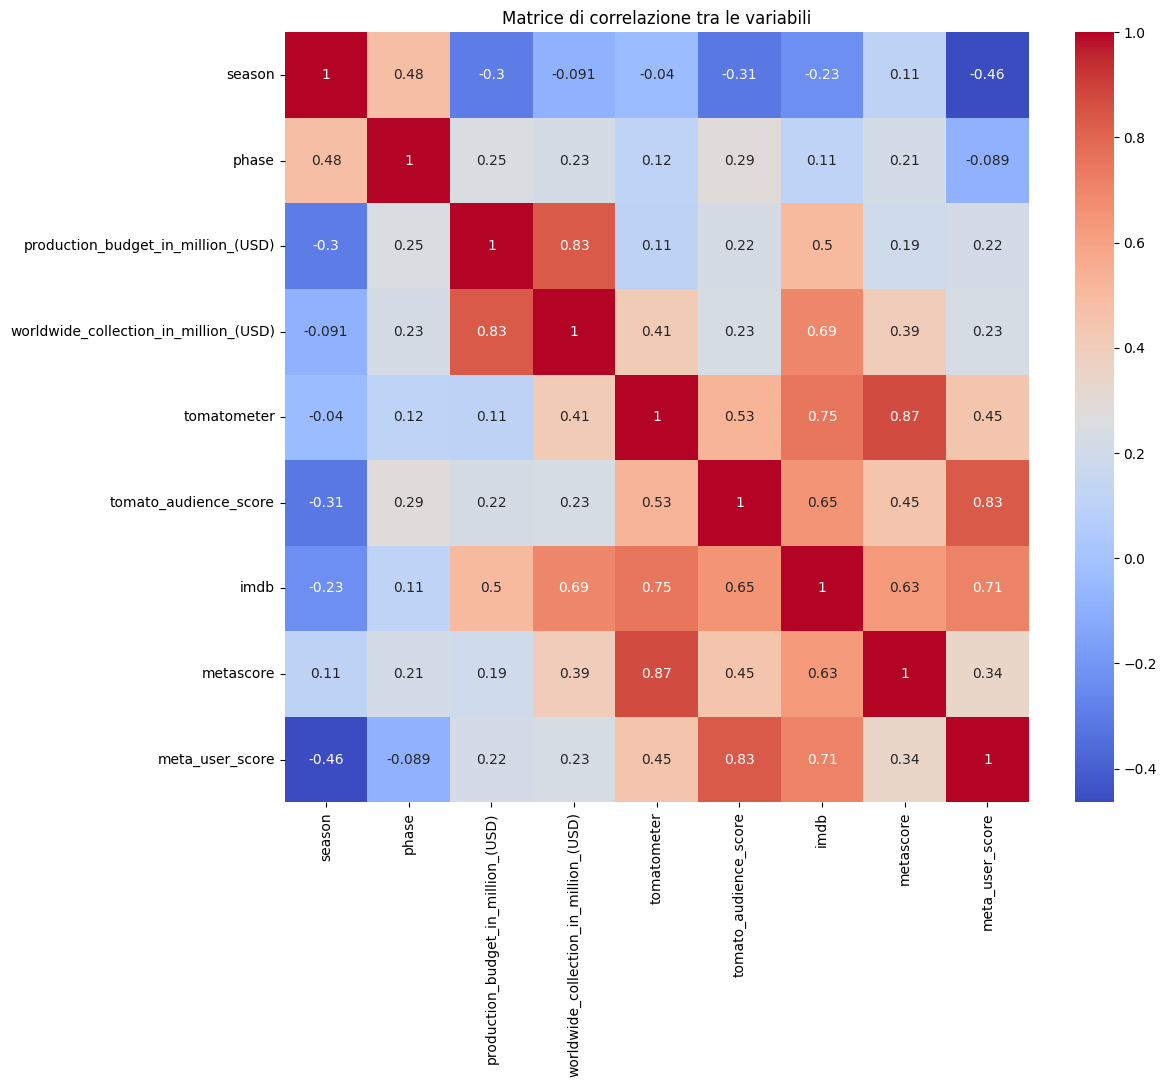

In [65]:
# Grafico preliminare della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice di correlazione tra le variabili')
plt.show()

In [69]:
# Seleziona solo le correlazioni relative alla variabile target
target_corr = corr_matrix['worldwide_collection_in_million_(USD)']

In [68]:
# Stabilisce una soglia di correlazione
threshold = 0.8

In [70]:
# Seleziona le colonne con una correlazione superiore alla soglia
selected_columns = target_corr[abs(target_corr) > threshold].index

In [71]:
# Mantiene solo le colonne selezionate nel dataset
data = data[selected_columns]

In [72]:
# Preparazione del dataset
X = data.drop('worldwide_collection_in_million_(USD)', axis=1)
y = data['worldwide_collection_in_million_(USD)']

In [73]:
# Divisione in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [74]:
# Modelli da confrontare
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=5),
    'Random Forest': RandomForestRegressor(random_state=5),
}

In [75]:
# Addestramento e valutazione dei modelli
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'{name} RMSE: {rmse}')

Linear Regression RMSE: 390.77817475891527
Support Vector Machine RMSE: 368.9880947191792
Decision Tree RMSE: 443.1496472223953
Random Forest RMSE: 436.55731720388707


In [76]:
# Cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{name} CV RMSE: {-scores.mean()}')

Linear Regression CV RMSE: 314.45075618281663
Support Vector Machine CV RMSE: 561.480050919764
Decision Tree CV RMSE: 395.9096431020159
Random Forest CV RMSE: 411.64721764811856


In [77]:
# Definizione della griglia di parametri per l'ottimizzazione degli iperparametri
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [78]:
# Ottimizzazione degli iperparametri con ricerca esaustiva Grid Search TOGLIERE PARAM GRID
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)
print('Best parameters:', grid_search.best_params_)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [17]:
# Addestramento e valutazione del modello ottimizzato
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
r2_score = best_rf.score(X_test, y_test)
print(f'Optimized Random Forest RMSE: {rmse}')
print(f'Optimized Random Forest MSE: {mse}')
print(f'Optimized Random Forest R²: {r2_score}')

Optimized Random Forest RMSE: 417.0611814918243
Optimized Random Forest MSE: 173940.02910735641
Optimized Random Forest R²: -0.32679896301991707


In [79]:
# Creazione di un grafico a barre per confrontare i vari algoritmi
rmse_scores = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores[name] = rmse

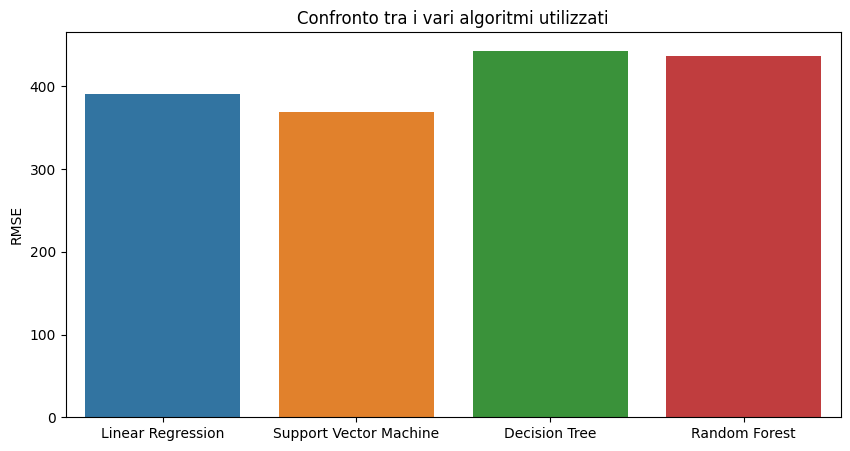

In [80]:
# Creazione del grafico a barre
plt.figure(figsize=(10, 5))
sns.barplot(x=list(rmse_scores.keys()),
y=list(rmse_scores.values()))
plt.ylabel('RMSE')
plt.title('Confronto tra i vari algoritmi utilizzati')
plt.show()

In [81]:
cv_rmse_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse_scores[name] = -scores.mean()

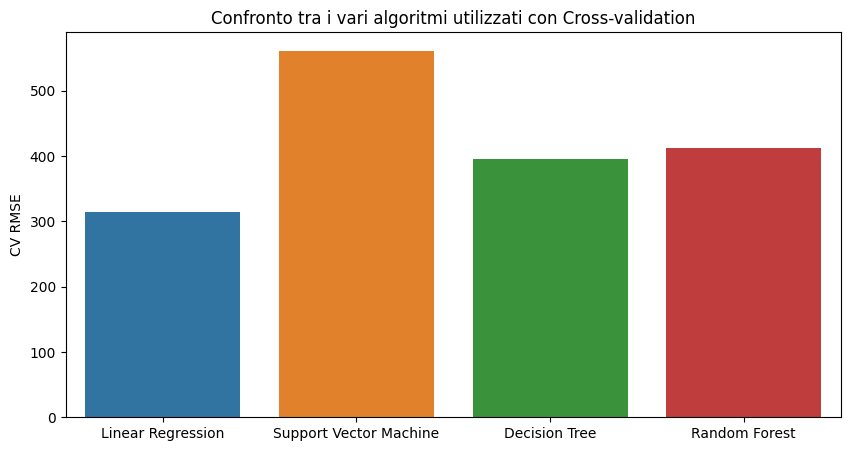

In [82]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(cv_rmse_scores.keys()), y=list(cv_rmse_scores.values()))
plt.ylabel('CV RMSE')
plt.title('Confronto tra i vari algoritmi utilizzati con Cross-validation')
plt.show()

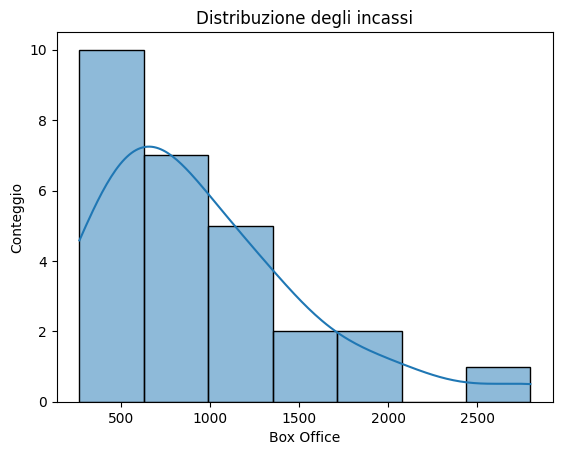

In [83]:
# Distribuzione degli incassi
sns.histplot(data['worldwide_collection_in_million_(USD)'], kde=True)
plt.xlabel('Box Office')
plt.ylabel('Conteggio')
plt.title('Distribuzione degli incassi')
plt.show()

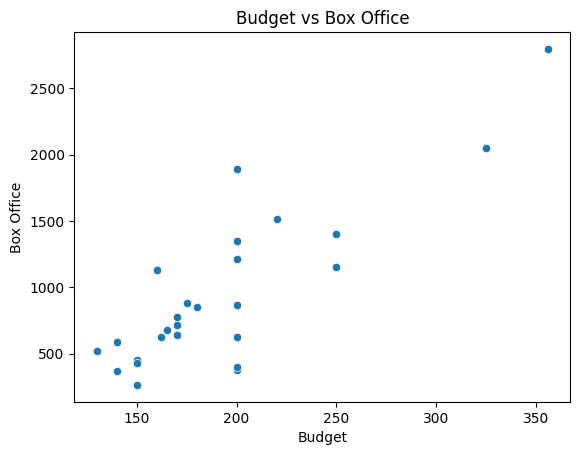

In [31]:
# Scatterplot tra budget e incasso
sns.scatterplot(x=data['production_budget_in_million_(USD)'], y=data['worldwide_collection_in_million_(USD)'])
plt.xlabel('Budget')
plt.ylabel('Box Office')
plt.title('Budget vs Box Office')
plt.show()

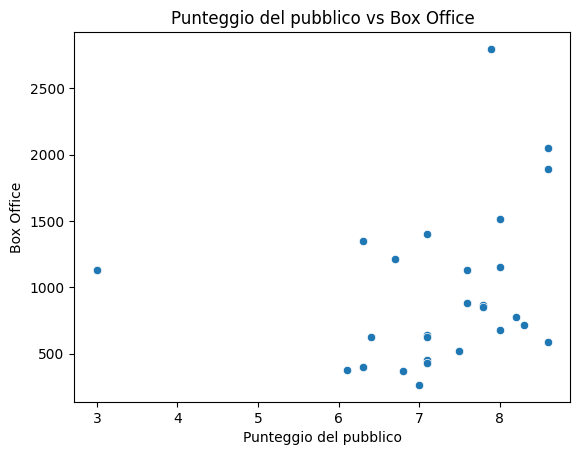

In [59]:
# Scatterplot tra valutazione degli spettatori e incasso
sns.scatterplot(x=data['meta_user_score'], y=data['worldwide_collection_in_million_(USD)'])
plt.xlabel('Punteggio del pubblico')
plt.ylabel('Box Office')
plt.title('Punteggio del pubblico vs Box Office')
plt.show()

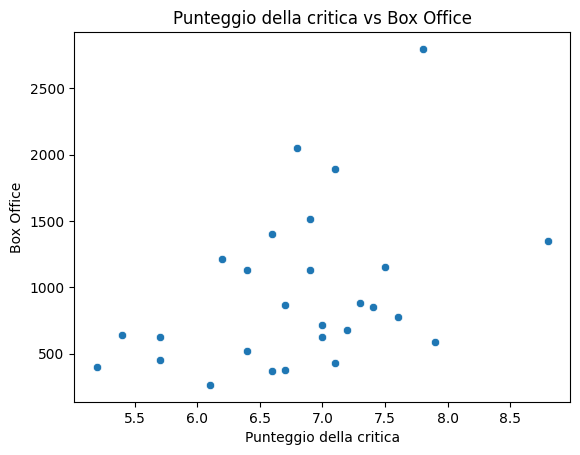

In [60]:
# Scatterplot tra valutazione della critica e incasso
sns.scatterplot(x=data['metascore'], y=data['worldwide_collection_in_million_(USD)'])
plt.xlabel('Punteggio della critica')
plt.ylabel('Box Office')
plt.title('Punteggio della critica vs Box Office')
plt.show()

In [ ]:
# AGGIUNGERE GRAFGICO PRELIMINARE (TIPO NELLA CORRELAZIONE) + GRAFICO DI CONFRONTO TRA VARI ALGORITMI 